# Model Exploration - Multiclass (ML50-2023)

## __Importing libraries__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
import time 
import pickle
import random

# Sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#### Importing the data

In [3]:
train = pd.read_csv('../Data/train_multiclass.csv', index_col=0)
test = pd.read_csv('../Data/test_multiclass.csv', index_col=0)
b_target = pd.read_csv('../Data/train_cleaned.csv', index_col=0)['b_target']

# Droping the target from the train and test
c_target = train['c_target']
train = train.drop(['c_target', 'c_patient'], axis=1)  
test = test.drop(['c_target', 'c_patient'], axis=1)

mapper = {
    'No' : 0,
    '>30 days' : 1, 
    '<30 days' : 2
}

c_target = c_target.map(mapper)

### __Small processing__

## __Functions__

In [5]:
def simple_sampler(X, y, minority_factor=1):
    X_res = pd.concat([X, y], axis=1)
    minority_class = X_res[X_res[y.name] == 1]
    majority_class = X_res[X_res[y.name] == 0]
    # Using the resample function to upsample the minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)
    upsampled = pd.concat([majority_class, minority_upsampled])
    X_train = upsampled.drop(columns=y.name)
    y_train = upsampled[y.name]
    return X_train, y_train

def multi_sampler(X,y, minority_factor=1):
    X_res = pd.concat([X, y], axis=1)
    max_class_count = X_res[y.name].value_counts().max()
    to_upsample = X_res[X_res[y.name] == X_res[y.name].value_counts().idxmax()]
    # Iterate over each class
    for class_index, group in X_res.groupby(y.name):
        if len(group) < max_class_count:
            # Upsample minority class
            minority_upsampled = resample(group, replace=True, 
                                        n_samples=max_class_count, 
                                        random_state=42)
            # Replace the original samples of the class in the dataframe with the upsampled data
            to_upsample = pd.concat([to_upsample, minority_upsampled])
    X_train = to_upsample.drop(columns=y.name)
    y_train = to_upsample[y.name]
    return X_train, y_train

In [6]:
def get_train_val(X_, y_, test_size=0.3, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, verbose=False, return_scaler=False):    
    X = X_.copy()
    y = y_.copy()
    multiclass = False
    # Check if y is multi-class
    if len(y.unique()) > 2:
        multiclass = True
        print('Multiclass variable') if verbose else None

    numeric_cols = [col for col in X.columns if col.startswith('n_')]
    if scaler:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Simple doesnt work for multiclass
    if sampler == 'simple' and multiclass:
        print('Multiclass sampling not supported for simple sampler') if verbose else None
        return None
    
    # Simple sampler 
    if sampler == 'simple':
        print(f'Simple sampling with minority factor {minority_factor}') if verbose else None
        X_train, y_train = simple_sampler(X_train, y_train, minority_factor=minority_factor)
    
    # Multiclass sampler
    elif sampler == 'multiclass':
        print('Using multiclass sampling') if verbose else None
        X_train, y_train = multi_sampler(X_train, y_train, minority_factor=minority_factor)
        
    # Using SMOTE to upsample the minority class, or other IMBLEARN samplers
    elif sampler:
        print('Using {} sampler'.format(sampler)) if verbose else None
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if return_scaler:
        return X_train, X_val, y_train, y_val, scaler
    else:
        return X_train, X_val, y_train, y_val 

In [7]:
def test_model(model, X_, y_, just_score=False, scaler=MinMaxScaler(), test_size=0.3, sampler='simple', minority_factor=1, verbose=False, return_scaler=False, return_X=False, average='weighted'): 
    X = X_.copy()
    y = y_.copy()

    multiclass = False
    # Check if y is multi-class
    if len(y.unique()) > 2:
        multiclass = True
    
    if return_scaler:
        X_train, X_test, y_train, y_test, scaler = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    else:
        X_train, X_test, y_train, y_test = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        if multiclass:
            return fit, f1_score(y_test, y_pred, average=average)
        return fit, f1_score(y_test, y_pred)  
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred)) if not multiclass else print('Precision: ', precision_score(y_test, y_pred, average=average))
    print('Recall: ', recall_score(y_test, y_pred)) if not multiclass else print('Recall: ', recall_score(y_test, y_pred, average=average))
    print('F1: ', f1_score(y_test, y_pred)) if not multiclass else print('F1: ', f1_score(y_test, y_pred, average=average))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    if return_scaler and return_X:
        return fit, scaler, X_test, y_test
    elif return_scaler:
        return fit, scaler
    elif return_X:
        return fit, X_test, y_test
    else :
        return fit

In [8]:
def test_model_cv(X_, y_, model, scaler=MinMaxScaler(), params=None, sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1, return_train_score=False, return_std=False, average='weighted'):
    X = X_.copy()
    y = y_.copy()

    multiclass = False
    # Check if y is multi-class
    if len(y.unique()) > 2:
        multiclass = True

    # Lets program the cv manually so that we can track the progress
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    print(params) if (verbose and params) else None
    if params and n_jobs:
        model = model(**params, random_state=42, n_jobs=n_jobs)
    elif params:
        model = model(**params, random_state=42)
        
    scores_test, scores_train = [], []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'Starting fold {i+1}/{cv}...') if verbose else None
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        # Scale the data
        if scaler:
            numeric_cols = [col for col in X_train.columns if col.startswith('n_')]
            X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Simple sampler
        if sampler == 'simple':
            if multiclass:
                print('Multiclass sampling not supported for simple sampler') if verbose else None
                return None
            
            X_train, y_train = simple_sampler(X_train, y_train, minority_factor=minority_factor)

        # Multi-class sampler
        elif sampler == 'multiclass':
            X_train, y_train = multi_sampler(X_train, y_train, minority_factor=minority_factor)

        # Other samplers
        elif sampler:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        
        # Score
        score_test = f1_score(y_test, y_pred) if not multiclass else f1_score(y_test, y_pred, average=average)
        score_train = f1_score(y_train, model.predict(X_train)) if not multiclass else f1_score(y_train, model.predict(X_train), average=average)
        scores_test.append(score_test)
        scores_train.append(score_train)

        if score_greedy and score_test < score_greedy and i < 1:
            print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}. Stopping early...') if verbose else None
            return score_test

        print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}') if verbose else None
    print(f'Average score: {np.mean(scores_test)} for params: {params}') if verbose else None
    if return_train_score and return_std:
        return np.mean(scores_test), np.std(scores_test), np.mean(scores_train), np.std(scores_train)
    elif return_train_score:
        return np.mean(scores_test), np.mean(scores_train)
    elif return_std:
        return np.mean(scores_test), np.std(scores_test)
    else:
        return np.mean(scores_test)
    

In [9]:
def random_search_manual(X_, y_, model, params, scaler, sampler='simple', iter=10, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1, return_scores=False):
    X = X_.copy()
    y = y_.copy()
    # We will use the test_model_cv function to perform the random search
    best_score = 0
    best_params = None
    scores_train, scores_test = {}, {}

    print(f'Doing {iter} iterations with {cv} folds, totally {iter*cv} fits...') if verbose else None
    for i in range(iter):
        print(f'Iteration {i+1}/{iter}...') if verbose else None
        params_ = {k : np.random.choice(v) for k, v in params.items() if k != 'hidden_layer_sizes'}
        if 'hidden_layer_sizes' in params:
            params_['hidden_layer_sizes'] = random.choice(params['hidden_layer_sizes'])
        score_test, score_train = test_model_cv(X_=X, y_=y, model=model, params=params_, scaler=scaler, sampler=sampler, minority_factor=1, cv=cv, scoring=scoring, verbose=verbose, score_greedy=score_greedy, n_jobs=n_jobs, return_train_score=True)
        if score_test > best_score:
            best_score = score_test
            best_params = params_
        scores_test[score_test] = params_
        scores_train[score_train] = params_
    
    print(f'Best score: {best_score} for params: {best_params}') if verbose else None
    return best_params if not return_scores else (best_params, scores_test, scores_train)

## __To help with the models__

### __Feature Selection Models__

#### __RFE - Logistic Regression__
- Using a scaler, because logistic regression is sensitive to the scale of the data.
- Using a sampler. RandomUnderSampler becaus it will lead to results faster.

In [ ]:
# Perform recursive feature elimination to select the best features
# Create the RFE object and rank each pixel
model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

# Scale the data
scaler = MinMaxScaler()
numerical_cols = [col for col in train.columns if col.startswith('n_')]
train_scaled = train.copy()
train_scaled[numerical_cols] = scaler.fit_transform(train_scaled[numerical_cols])

# Upsample the data
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(train_scaled, c_target)

# Fit the model
rfe_log = RFECV(model, min_features_to_select=5, verbose=1, step=1, cv=5, scoring='f1_weighted')
rfe_log = rfe_log.fit(X_train, y_train)

In [11]:
# Check if the variable rfe_log exists, if not, load it from the file
if 'rfe_log' not in locals():
    # Get it from a pickle file
    with open('../Pickles/multi_rfe_log.pkl', 'rb') as f:
        rfe_log = pickle.load(f)
    
# Create a dataframe with the feature importances
log_importances = pd.DataFrame({'feature': train.columns, 'importance': rfe_log.ranking_}).sort_values('importance', ascending=True)
log_importances

,feature,importance
148,n_times_visited,1
137,b_disp_Inpatient Care,1
135,b_disp_Hospice,1
132,b_disp_High Readmission,1
131,b_disp_Expired,1
...,...,...
93,b_diag3_simple_16,137
9,b_changeMeds,138
97,b_diabetes_250,139
57,b_diag1_simple_9,140


#### __RFE - XGBoost__
- No need to scale (tree based model) but sampling will be done.

In [ ]:
# Upsample the data
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(train, c_target) 

# Encode y_train
mapper = {'<30 days': 0, '>30 days': 1, 'No': 2}
y_train = y_train.map(mapper)

# Select the best features
model = XGBClassifier(random_state=42, n_estimators=250)
rfe_xgb = RFECV(model, min_features_to_select=5, verbose=1, step=1, cv=5, scoring='f1_weighted')
rfe_xgb = rfe_xgb.fit(X_train, y_train)

In [12]:
if 'rfe_xgb' not in locals():
    # Get it from a pickle file
    with open('../Pickles/multi_rfe_xgb.pkl', 'rb') as f:
        rfe_xgb = pickle.load(f)

# Create a dataframe with the feature importances
xgb_importances = pd.DataFrame({'feature': train.columns, 'importance': rfe_xgb.ranking_}).sort_values('importance', ascending=True)
xgb_importances

,feature,importance
0,b_gender,1
99,b_diabetes_250.1,1
98,b_diabetes_250.02,1
97,b_diabetes_250,1
96,b_diag3_simple_19,1
...,...,...
92,b_diag3_simple_14,35
102,b_diabetes_250.22,36
43,b_specialty_Psychology,37
125,b_noMeds,38


#### __Regularization - Lasso__
- Getting the best C value for the model.
- Using lasso (L1) so that coefficients get shrinked to 0 and we can see which features are the most important.

In [ ]:
model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)

# Initialize the C values
C_range = np.linspace(0.001, 1, 50)
stats_lasso = pd.DataFrame()

# Scale the data 
scaler = MinMaxScaler()
train_scaled = train.copy()
numerical_cols = [col for col in train.columns if col.startswith('n_')]
train_scaled[numerical_cols] = scaler.fit_transform(train_scaled[numerical_cols])

# Upsample the data
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(train_scaled, c_target)

for c_value in C_range:
    print(f'Fitting model with C value {c_value}...')

    model.set_params(C=c_value)

    # Get the scores
    scores_test, std_test, scores_train, std_train = test_model_cv(
        X_=train,
        y_=c_target,
        model=model,
        scaler=MinMaxScaler(),
        sampler='multiclass',
        cv=5,
        scoring='f1_weighted',
        verbose=True,
        return_train_score=True,
        return_std=True,
    )

    start = time.time()
    # Fit the model to get the coefficients

    model.fit(X_train, y_train)
    end = time.time()

    # Create a dataframe with the feature importances
    feature_importances = pd.DataFrame({'feature': train.columns, 'importance': model.coef_[0]}).sort_values('importance', ascending=False)
    coef = len(feature_importances[feature_importances['importance'] != 0])

    time_fit = end - start

    stats_lasso = stats_lasso.append({
        'C' : c_value,
        'score_test' : scores_test,
        'score_train' : scores_train,
        'std_test' : std_test,
        'std_train' : std_train,
        'n_features' : coef,
        'time_fit' : time_fit
    }, ignore_index=True)

<Axes: title={'center': 'Test score for every C value between 0.001 and 1'}>

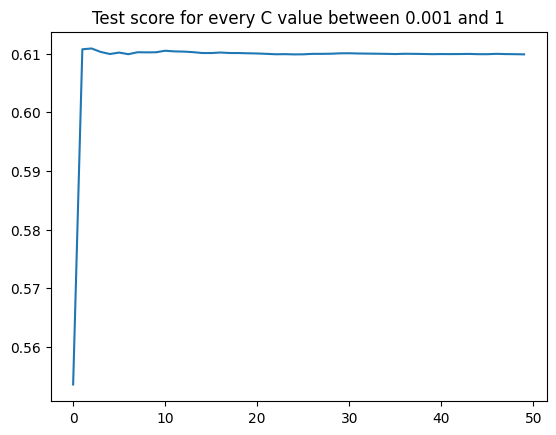

In [25]:
stats_lasso['score_test'].plot(title='Test score for every C value between 0.001 and 1')

We will simply chose a C of 0.005 

In [13]:
# Now fit the lasso regression to get the coefficients
model = LogisticRegression(penalty='l1', random_state=42, max_iter=500, C=0.005, solver='saga', multi_class='multinomial')

# Scale the data 
scaler = MinMaxScaler()
train_scaled = train.copy()
numerical_cols = [col for col in train.columns if col.startswith('n_')]
train_scaled[numerical_cols] = scaler.fit_transform(train_scaled[numerical_cols])

# Upsample the data
X_train, y_train = RandomOverSampler(random_state=42).fit_resample(train_scaled, c_target)

# Fit the model
model.fit(X_train, y_train)
coef = model.coef_[0]
coef = pd.DataFrame({'feature': train.columns, 'coef': coef}).sort_values('coef', ascending=False)
len(coef[coef['coef'] != 0])

26

<Axes: title={'center': 'Coefficients for the Lasso regression'}, xlabel='feature'>

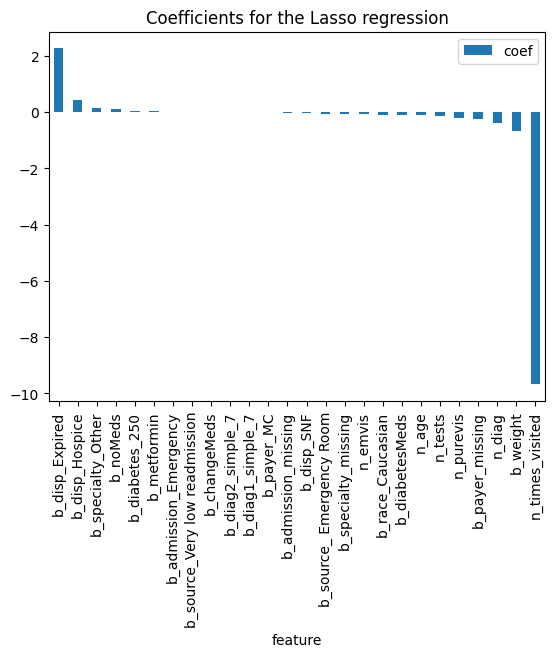

In [14]:
coef[coef['coef'] != 0].plot(kind='bar', x='feature', y='coef', title='Coefficients for the Lasso regression')

In [27]:
len(coef[coef['coef']!=0])

26

### __Selecting the features__

In [15]:
merged_importances = pd.merge(log_importances, xgb_importances, on='feature', how='inner')
merged_importances = pd.merge(merged_importances, coef, on='feature', how='inner')
merged_importances.set_index('feature', inplace=True)

# Change the coef to absolute value
merged_importances['coef'] = merged_importances['coef'].abs()

# Now rank the coef
merged_importances['coef'] = merged_importances['coef'].rank(ascending=False)

merged_importances.columns = ['log_rank', 'xgb_rank', 'coef_rank']

# Scale each rank to range from 0 to 100
merged_importances['log_rank'] = (merged_importances['log_rank'] - merged_importances['log_rank'].min()) / (merged_importances['log_rank'].max() - merged_importances['log_rank'].min()) * 100
merged_importances['xgb_rank'] = (merged_importances['xgb_rank'] - merged_importances['xgb_rank'].min()) / (merged_importances['xgb_rank'].max() - merged_importances['xgb_rank'].min()) * 100
merged_importances['coef_rank'] = (merged_importances['coef_rank'] - merged_importances['coef_rank'].min()) / (merged_importances['coef_rank'].max() - merged_importances['coef_rank'].min()) * 100

merged_importances['final_rank'] = merged_importances['log_rank'] + merged_importances['xgb_rank'] + merged_importances['coef_rank']

# Rank the final rank
merged_importances['final_rank'] = merged_importances['final_rank'].rank(ascending=True)
merged_importances.sort_values('final_rank', ascending=True, inplace=True)
merged_importances.head(30)

,log_rank,xgb_rank,coef_rank,final_rank
feature,,,,
n_times_visited,0.000000,0.0,0.000000,1.0
b_disp_Expired,0.000000,0.0,1.149425,2.0
b_weight,0.000000,0.0,2.298851,3.0
b_disp_Hospice,0.000000,0.0,3.448276,4.0
n_diag,3.571429,0.0,4.597701,5.0
n_purevis,2.142857,0.0,6.896552,6.0
b_payer_missing,14.285714,0.0,5.747126,7.0
n_age,12.857143,0.0,10.344828,8.0
b_disp_SNF,7.857143,0.0,20.689655,9.0


In [16]:
# Lets keep until final_rank == 25
selected_features = merged_importances[merged_importances['final_rank'] <= 25].index.tolist()
X = train[selected_features]
y = c_target

## __Models__

### __Logistic Regression (0.613)__

In [63]:
# Fit a logistic regression to the X and y
log_clf = LogisticRegression(random_state=42, max_iter=500, solver='saga', multi_class='multinomial')

test_model(
    model=log_clf,
    X_=X,
    y_=y,
    scaler=MinMaxScaler(),
    sampler='multiclass',
    minority_factor=1,
    verbose=True,
    return_scaler=False,
    return_X=False,
    average='weighted'
)


Multiclass variable
Using multiclass sampling
Accuracy:  0.613804398689752
Precision:  0.6331850272185688
Recall:  0.613804398689752
F1:  0.6131416107184587
Confusion matrix: 
 [[9255 1267  999]
 [2555 2866 2043]
 [ 624  765  996]]
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     11521
           1       0.59      0.38      0.46      7464
           2       0.25      0.42      0.31      2385

    accuracy                           0.61     21370
   macro avg       0.53      0.53      0.52     21370
weighted avg       0.63      0.61      0.61     21370



LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42,
                   solver='saga')

### __XGBoost (0.635)__

In [70]:
xgb_clf = XGBClassifier(random_state=42, n_estimators=250)

test_model(
    model=xgb_clf,
    X_=X,
    y_=y,
    scaler=None,
    sampler='multiclass',
    minority_factor=1,
    average='weighted',
)

Accuracy:  0.6212915301824988
Precision:  0.6306159181190999
Recall:  0.6212915301824988
F1:  0.6214203819550904
Confusion matrix: 
 [[9259 1474  788]
 [2424 3214 1826]
 [ 570 1011  804]]
Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     11521
           1       0.56      0.43      0.49      7464
           2       0.24      0.34      0.28      2385

    accuracy                           0.62     21370
   macro avg       0.52      0.52      0.51     21370
weighted avg       0.63      0.62      0.62     21370



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

##### Hyperparameter Tuning

In [ ]:
param_dict = {
    'n_estimators' : [val for val in range(50, 400,2)],
    'max_depth' : [val for val in range(2, 30)],
    'learning_rate' : [val for val in np.arange(0.01, 0.5, 0.01)],
    'gamma' : [val for val in np.arange(0, 1, 0.01)],
    'min_child_weight' : [val for val in range(1, 15)],
    'subsample' : [val for val in np.arange(0.5, 1, 0.01)],
    'colsample_bytree' : [val for val in np.arange(0.5, 1, 0.01)],
}

best_estimator = random_search_manual(X, y, model=XGBClassifier, params=param_dict, sampler='multiclass', scaler=None, iter=50, score_greedy=0.35, cv=5)

In [76]:
best_estimator = {'n_estimators': 260, 'max_depth': 22, 'learning_rate': 0.02, 'gamma': 0.03, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.54}

test_model(
    model=XGBClassifier(**best_estimator, random_state=42),
    X_=X,
    y_=y,
    scaler=None,
    sampler='multiclass',
    minority_factor=1,
    average='weighted',
)

Accuracy:  0.6467009826860084
Precision:  0.6289889250164786
Recall:  0.6467009826860084
F1:  0.6354525287565499
Confusion matrix: 
 [[9534 1606  381]
 [2683 3779 1002]
 [ 666 1212  507]]
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.83      0.78     11521
           1       0.57      0.51      0.54      7464
           2       0.27      0.21      0.24      2385

    accuracy                           0.65     21370
   macro avg       0.53      0.52      0.52     21370
weighted avg       0.63      0.65      0.64     21370



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.54, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=260, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### __Random Forest (0.642)__

In [74]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=250)

test_model(
    model=rf_clf,
    X_=X,
    y_=y,
    scaler=None,
    sampler='multiclass',
    minority_factor=1,
    verbose=True,
    average='weighted'
)

Multiclass variable
Using multiclass sampling
Accuracy:  0.6289190453907346
Precision:  0.6109551232925055
Recall:  0.6289190453907346
F1:  0.6183574087830093
Confusion matrix: 
 [[9185 1892  444]
 [2740 3824  900]
 [ 698 1256  431]]
Classification report: 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76     11521
           1       0.55      0.51      0.53      7464
           2       0.24      0.18      0.21      2385

    accuracy                           0.63     21370
   macro avg       0.51      0.50      0.50     21370
weighted avg       0.61      0.63      0.62     21370



RandomForestClassifier(n_estimators=250, random_state=42)

##### Hyperparameter Tuning

In [79]:
params_dict = {
  'n_estimators': [val for val in range(60, 300)],
  'max_depth': [val for val in range(10, 25)],
  'min_samples_split': [val for val in range(2,15)],
  'min_samples_leaf': [val for val in range(2,15)],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': [None],
}


best_estimator = random_search_manual(X, y, model=RandomForestClassifier, params=params_dict, 
                                      scaler=None, iter=25, sampler='multiclass', cv=5)

Doing 25 iterations with 5 folds, totally 125 fits...
Iteration 1/25...
{'n_estimators': 240, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.6516017890628728, score test: 0.6159128647586127
Starting fold 2/5...
Finished fold 2/5. Score train: 0.6502966359636541, score test: 0.6203960748736207
Starting fold 3/5...
Finished fold 3/5. Score train: 0.6530088936628102, score test: 0.6198215554659084
Starting fold 4/5...
Finished fold 4/5. Score train: 0.649013223728621, score test: 0.6108747464176262
Starting fold 5/5...
Finished fold 5/5. Score train: 0.6551862744269219, score test: 0.6215489553312468
Average score: 0.617710839369403 for params: {'n_estimators': 240, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None}
Iteration 

####  Feature Importances

In [83]:
# Get the feature importances
best_estimator = {'n_estimators': 220, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None}
model = RandomForestClassifier(**best_estimator, random_state=42)

test_model(
    model=model,
    X_=X,
    y_=y,
    scaler=None,
    sampler='multiclass',
    minority_factor=1,
    verbose=True,
    average='weighted'
)


Multiclass variable
Using multiclass sampling
Accuracy:  0.6482919981282171
Precision:  0.6400110865679014
Recall:  0.6482919981282171
F1:  0.6415117762461084
Confusion matrix: 
 [[9577 1462  482]
 [2531 3613 1320]
 [ 600 1121  664]]
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79     11521
           1       0.58      0.48      0.53      7464
           2       0.27      0.28      0.27      2385

    accuracy                           0.65     21370
   macro avg       0.54      0.53      0.53     21370
weighted avg       0.64      0.65      0.64     21370



RandomForestClassifier(bootstrap=False, max_depth=19, max_features='log2',
                       min_samples_leaf=2, n_estimators=220, random_state=42)

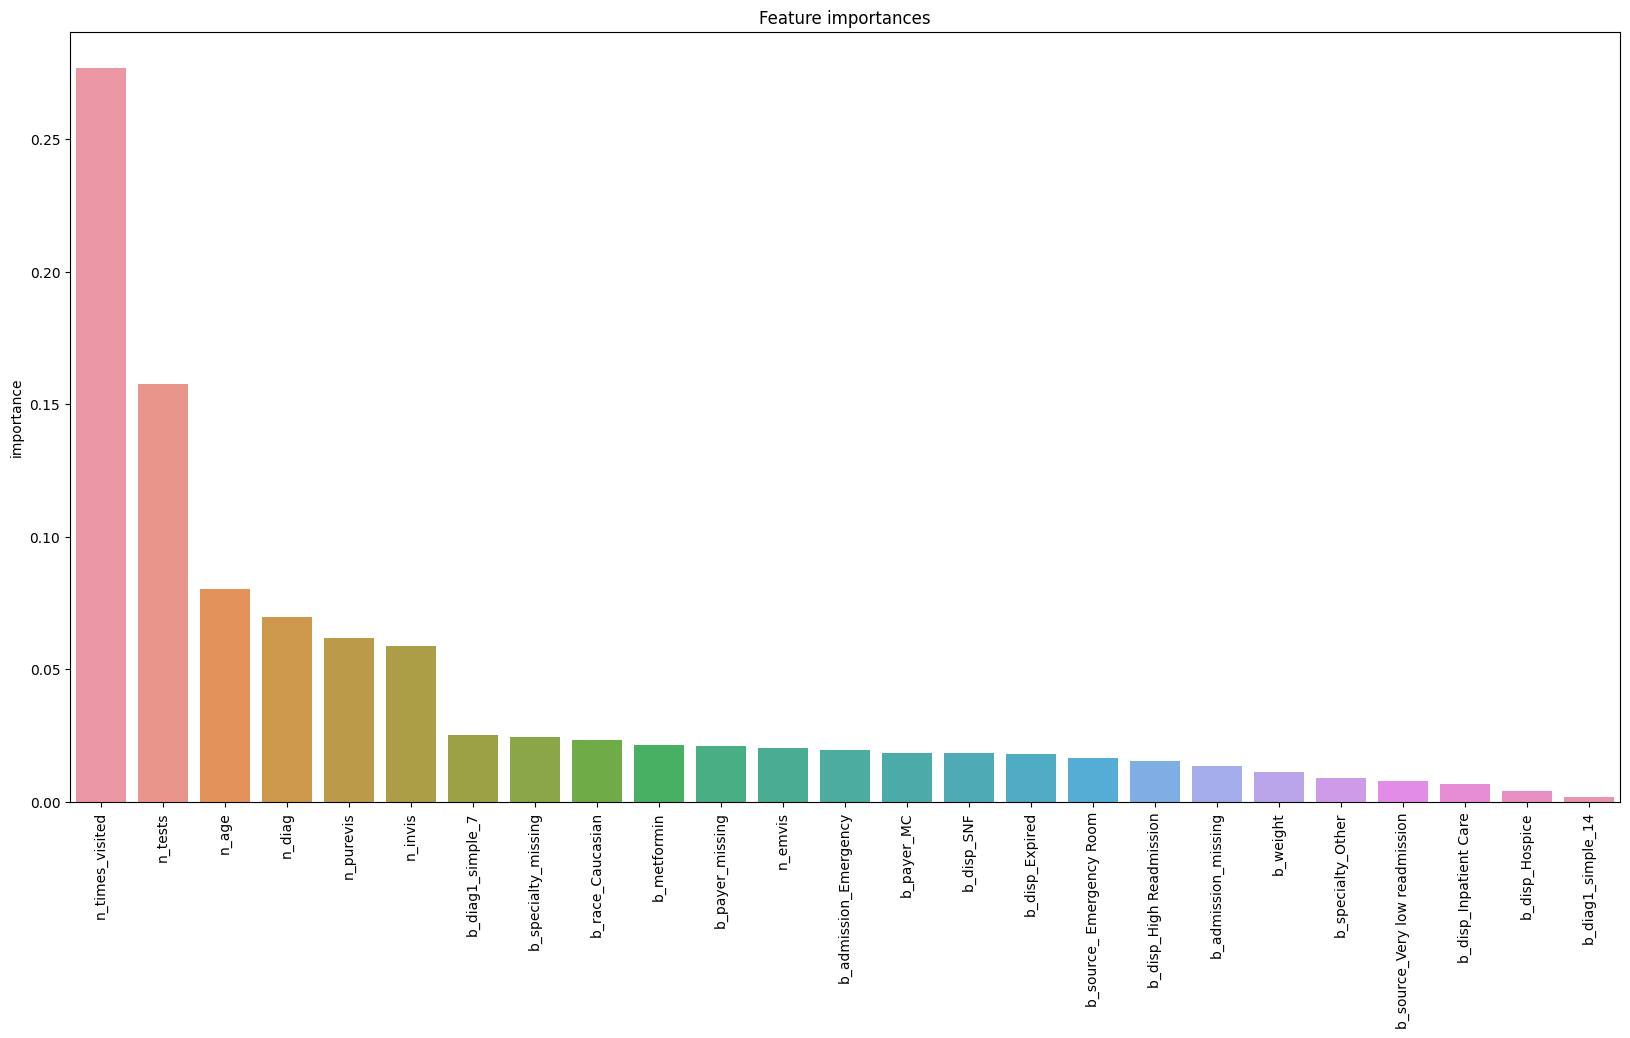

In [95]:
fit_rf, _ = test_model(model=model,X_=X,y_=y,scaler=None,sampler='multiclass',minority_factor=1,verbose=True,average='weighted', just_score=True)

feature_importances = pd.DataFrame(fit_rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.title('Feature importances')
plt.show()

### __MPL Classifier (0.601)__

In [96]:
mpl_clf = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(10,10,10,10))

test_model(
    model=mpl_clf,
    X_=X,
    y_=y,
    scaler=MinMaxScaler(),
    sampler='multiclass',
    minority_factor=1,
    verbose=True,
    return_scaler=False,
    return_X=False,
    average='weighted'
)

Multiclass variable
Using multiclass sampling
Accuracy:  0.5909218530650444
Precision:  0.6341935852916993
Recall:  0.5909218530650444
F1:  0.5992993635650812
Confusion matrix: 
 [[8777 1487 1257]
 [2101 2622 2741]
 [ 465  691 1229]]
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.76      0.77     11521
           1       0.55      0.35      0.43      7464
           2       0.24      0.52      0.32      2385

    accuracy                           0.59     21370
   macro avg       0.52      0.54      0.51     21370
weighted avg       0.63      0.59      0.60     21370



MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=500,
              random_state=42)

##### Model tunning

In [ ]:
param_dict = {
    'hidden_layer_sizes': [(5,5,5), (10,10,10), (4,4,4,4), (10,10,10,10), (25,25), (50), (100), (50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'batch_size': [5, 50, 100, 200, 500, 5000, 20000],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'power_t': [0.5, 0.6, 0.7],
    'max_iter': [1500],
    'verbose' : [False],
    'shuffle': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'warm_start': [False, True],
    'momentum': [0.9, 0.95, 0.99],
    'nesterovs_momentum': [True, False],
    'early_stopping': [False, True],
    'validation_fraction': [0.1, 0.2, 0.3],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.999, 0.995, 0.99],
    'epsilon': [1e-8, 1e-7, 1e-6],
    'n_iter_no_change': [5, 10, 15]
}

best_estimator = random_search_manual(X, y, model=MLPClassifier, params=param_dict, sampler='multiclass', scaler=MinMaxScaler(), iter=20, score_greedy=None, cv=5, n_jobs=None)

In [22]:
best_params = {'activation': 'relu', 'solver': 'adam', 'alpha': 0.05, 'batch_size': 500, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 1500, 'verbose': False, 'shuffle': True, 'tol': 0.0001, 'warm_start': True, 'momentum': 0.95, 'nesterovs_momentum': False, 'early_stopping': False, 'validation_fraction': 0.2, 'beta_1': 0.95, 'beta_2': 0.99, 'epsilon': 1e-08, 'n_iter_no_change': 15, 'hidden_layer_sizes': (50, 50)}

model = MLPClassifier(**best_params, random_state=42)

test_model(
    model=model,
    X_=X,
    y_=y,
    scaler=MinMaxScaler(),
    sampler='multiclass',
    minority_factor=1,
    verbose=True,
    return_scaler=False,
    return_X=False,
    average='weighted'
)

Multiclass variable
Using multiclass sampling
Accuracy:  0.5934955545156761
Precision:  0.6329478525607571
Recall:  0.5934955545156761
F1:  0.6010220998075787
Confusion matrix: 
 [[8938 1269 1314]
 [2239 2690 2535]
 [ 515  815 1055]]
Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77     11521
           1       0.56      0.36      0.44      7464
           2       0.22      0.44      0.29      2385

    accuracy                           0.59     21370
   macro avg       0.51      0.53      0.50     21370
weighted avg       0.63      0.59      0.60     21370



MLPClassifier(alpha=0.05, batch_size=500, beta_1=0.95, beta_2=0.99,
              hidden_layer_sizes=(50, 50), max_iter=1500, momentum=0.95,
              n_iter_no_change=15, nesterovs_momentum=False, random_state=42,
              validation_fraction=0.2, warm_start=True)